Initialize the NvidiaRacecar object (it might take a while)

In [ ]:
from jetracer.nvidia_racecar import NvidiaRacecar
import numpy as np

car = NvidiaRacecar()

In [ ]:
print(1)

Initialize the camera (in case it doesn't work restart kernel!)

In [ ]:
from jetcam.csi_camera import CSICamera

camera = CSICamera(width=64, height=64, capture_fps=30)

Load the model

In [ ]:
import onnxruntime as ort

# Upload model ONNX
MODEL_PATH = 'keras_inversed_images_5.onnx'
road_recognition = ort.InferenceSession(MODEL_PATH)

Basically, the car is controlled by adjusting 2 ``NvidiaRacecar`` attributes - ``NvidiaRacecar.steering`` and ``NvidiaRacecar.throttle``.

``NvidiaRacecar.steering`` controls the angle of front wheels. The value varies [-1;1], where -1 means full left, 0 - straight, and 1 - full right.

``NvidiaRacecar.throttle`` manages the car's acceleration, with values ranging [-1;1], where -1 means full reverse, 0 is a complete stop, and 1 is maximum forward acceleration. *ATTENTION - USE SMALL VALUES, THE CAR IS EXTREMELY FAST!*

In [ ]:
car.steering = 0
car.throttle = 0.0

In [ ]:
print(car.throttle_gain)

Check the input & output names of the model:

In [ ]:
# Print all input and output names
input_names = [input.name for input in road_recognition.get_inputs()]
output_names = [output.name for output in road_recognition.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

Input names: ['conv2d_3_input']
Output names: ['dense_3']


Here I introduce an optional function that makes the car turn more smoothly. For segments [-1;-0.5] and [0.5;1] x becomes smaller in absolute value, which makes car turn not so sharply on low speed.

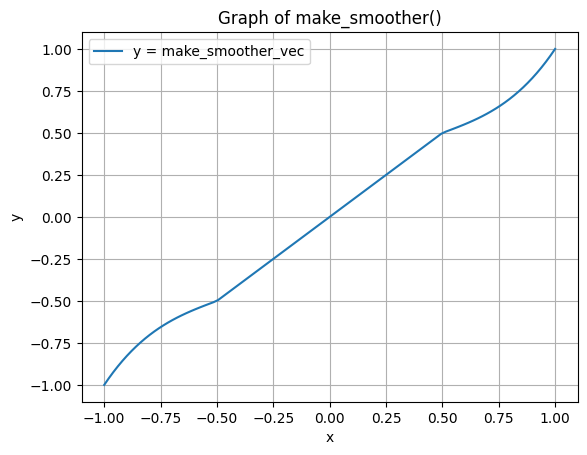

In [13]:
def make_smoother(x):
    negative = False
    if x <= 0:
        negative = True
        x = -x
    if x > 0.5:
        res = 2 * x - 3 * x * x + 2 * x * x * x
    else:
        res = x

    if negative:
        return -res
    return res


# and print the graph of this func
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)  # 100 points on [-1, 1]
make_smoother_vec = np.vectorize(make_smoother)
y = make_smoother_vec(x)

plt.plot(x, y, label="y = make_smoother_vec")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Graph of make_smoother()")
plt.legend()
plt.grid(True)
plt.show()


The main runable code for driving. Just stopping the execution will not stop the car, use stop button!

In [ ]:
import cv2
import numpy as np
from IPython.display import display
import threading
from math import sqrt
from jupyter_clickable_image_widget import ClickableImageWidget
from jetcam.utils import bgr8_to_jpeg
import ipywidgets as widgets
import traitlets

# Create stop button
stop_button = widgets.Button(description="Stop")

# stop flag
stop_flag = False

# stop button function
def on_button_clicked(b):
    global stop_flag
    stop_flag = True
    car.throttle = 0.0
    car.steering = 0

stop_button.on_click(on_button_clicked)
display(stop_button)

# Setup video (uncomment if needed to record)
# fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Choose codex
# out = cv2.VideoWriter('final-sign-video2.avi', fourcc, 30.0, (224, 224))  # create object for recording


# Main
def drive():
    global stop_flag
    stop_flag = False
    car.throttle = 0.21
    while not stop_flag:
        image = camera.read()

        # recording (uncomment if needed to record)
        # image_bgr = image
        # out.write(cv2.cvtColor(image_bgr, cv2.COLOR_RGB2BGR))  # making i n to RBG for recording


        dimage = cv2.resize(image, (64, 64))
        dimage = dimage.astype(np.float32) / 255.0
        dimage = np.expand_dims(dimage, axis=0)
        dimage = np.transpose(dimage, (0, 1, 2, 3))

        res = float(road_recognition.run(["dense_3"], {'conv2d_3_input': dimage})[0][0])

        res = make_smoother(res)

        car.steering = res


    # Releasing a video recording resource (uncomment if needed to record)
    # out.release()

# Run in a separate thread to be able to stop the while cycle via button
drive_thread = threading.Thread(target=drive)
drive_thread.start()


Button(description='Stop', style=ButtonStyle())